# **PACKAGES LOADING :**

In [6]:
# TENSORFLOW PACKAGE
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

# KERAS PACKAGE
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import backend as K

# SKLEARN PACKAGE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve,cohen_kappa_score

# OTHER PACKAGES
from tqdm import tqdm
from functools import partial
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pickle
import random
import gc
import json
import math
import scipy
import itertools
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow # to visualize correctly input images
%matplotlib inline

#**DRIVE SETTINGS**

In [7]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/deep_project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/deep_project'
/content


# **CONFUSION MATRIX HOME-MADE FUNCTION :**

In [8]:
def print_confusion_matrix(model, X, y):
    """
    Description:
    ----------
    This function plot the confusion matrix based on the testing data (X_test,Y_test).
    ----------
    Inputs:
    ----------
    model : CNN model used
    X : Target Dataset.
    y : Target Labels.
    Outputs:
    ----------
    conf_matrix:
        Confusion Matrix Plot.
    ----------
    """
    # Model Predictions:
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred,axis=1)
    # Confusion Matrix:
    conf_matrix = confusion_matrix(y, y_pred,normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(conf_matrix, ax=ax,cmap='Blues', square=True, vmin=0, vmax=1, annot=True, 
                linewidths=.05, fmt=".2f", cbar_kws={"shrink":.8}, 
                xticklabels='auto', yticklabels='auto')
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return 

# **KAGGLE DATASET LOADING :**

**Dataset Loader Function :**

In [9]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    """
    Description:
    ----------
    The function loads the image IMG storaged in the folder DIR and resizes it by RESIZE .

    Inputs:
    ----------
    DIR : Directory Path where the Image is Stored.
    RESIZE : Image Resize Dimension.

    Outputs:
    ----------
    IMG:Loaded Image with the format [RESIZE x RESIZE].
    """
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = cv2.imread(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE), 0)           
            IMG.append(np.array(img))
    return IMG

**Kaggle Dataset Loading :**

In [11]:
benign_train = np.array(Dataset_loader('/content/drive/MyDrive/deep_project/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/deep_project/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/deep_project/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/deep_project/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:11<00:00, 33.06it/s]


**Dataset Composition :**

In [12]:
# TrainingSet 
l_train_b = len(benign_train) # Benign
l_train_m = len(malign_train) # Malign
l_train = l_train_b+l_train_m # Malign + Benign
# TestingSet
l_test_b = len(benign_test) # Benign
l_test_m = len(malign_test) # Malign
l_test = l_test_b+l_test_m # Malign + Benign
# Entire Dataset
l_tot_b = l_test_b + l_train_b # Benign
l_tot_m = l_test_m + l_train_m # Malign
l_tot = l_test+l_train # Malign + Benign

**Pie Chart Benignant/Malignant Kaggle Dataset :**

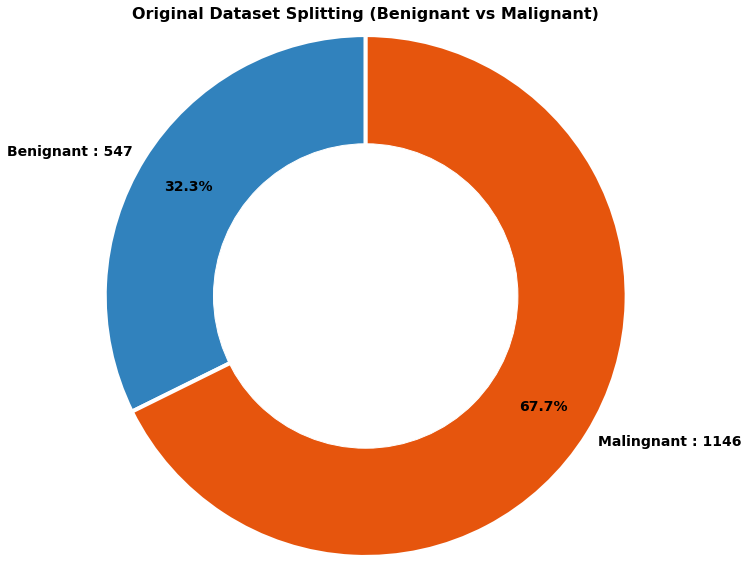

In [13]:
names = [f'Benignant : { l_tot_b}', f'Malingnant : { l_tot_m}']
size = [l_tot_b, l_tot_m]
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(3)*4)
# Setting the size of the figure
plt.figure(figsize=(10,10))
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')
# Custom wedges
plt.pie(size, labels = names, 
       startangle=90, pctdistance =0.80 ,colors=colors,
       autopct = '%1.1f%%', radius= 1.2, labeldistance=1.05,
       textprops ={ 'fontweight': 'bold','fontsize':14},
       wedgeprops = {'linewidth' : 4, 'edgecolor' : "w" } )
p = plt.gcf()
p.gca().add_artist(my_circle)
# Pie Chart Title
plt.title('Original Dataset Splitting (Benignant vs Malignant)',{'fontweight': 'bold','fontsize':16})
plt.show()

# **CNN DATASETS GENERATION :**

In [14]:
# Kaggle Dataset Labels
benign_train_label = np.zeros(len(benign_train)) # 0
malign_train_label = np.ones(len(malign_train)) # 1
benign_test_label = np.zeros(len(benign_test)) # 0
malign_test_label = np.ones(len(malign_test)) # 1
label =  {0:"benignant",1:"malignant"}

# Merge Kaggle Dataset (CNN Datasets)
X_train = np.concatenate((benign_train, malign_train), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)

# Merge Kaggle Labels into Categorical (0/1)
y_train = pd.Series(np.concatenate((benign_train_label, malign_train_label), axis = 0),dtype='category')
y_test = pd.Series(np.concatenate((benign_test_label, malign_test_label), axis = 0),dtype='category')

# Shuffle CNN TrainingSet
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1] # Shuffled TrainingSet
y_train = y_train[s1] # for PIE CHART (0/1)

# Shuffle CNN TestingingSet
s1 = np.arange(X_test.shape[0])
np.random.shuffle(s1)
X_test = X_test[s1] # Shuffled CNN TestingSet
y_test = y_test[s1] # for PIE CHART

# New CNN Training/Validation Set Generation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,y_train,
    test_size = 0.2, # The ValidationSet correspond to the 20% of the CNN TrainingSet
    random_state = 11)

Y_train = to_categorical(y_train, num_classes= 2) # for CNN ([0,1]/[1,0])
Y_val = to_categorical(y_val, num_classes= 2) # for CNN ([0,1]/[1,0])
Y_test = to_categorical(y_test, num_classes= 2) # for CNN ([0,1]/[1,0])

**VERY IMPORTANT OBSERVATION**: We use y_test/y_val/y_train variables only for graphical purposes and we use Y_test/Y_val/Y_train as elements for the current CNN. We will use this type of nomenclature for the code cells above.

**CNN Datasets Dimensions:**


In [15]:
# TrainingSet
l_train_b_new = sum(y_train==0) # Benign
l_train_m_new = sum(y_train==1) # Malign
l_train_new = l_train_b_new + l_train_m_new # Malign + Benign
# ValidationSet
l_val_b_new = sum(y_val==0) # Benign
l_val_m_new = sum(y_val==1) # Malign
l_val_new = l_val_b_new + l_val_m_new # Malign + Benign
# TestingSet
l_test_b_new = sum(y_test==0)  # Benign
l_test_m_new = sum(y_test==1) # Malign
l_test_new = l_test_b_new + l_test_m_new # Malign + Benign
# Entire Dataset
l_tot_b_new = l_test_b_new + l_train_b_new + l_val_b_new # Benign
l_tot_m_new = l_test_m_new + l_train_m_new + l_val_m_new # Malign
l_tot_new = l_test_new + l_train_new + l_val_new# Malign + Benign

**Nested Pie Chart of CNN Dataset (Without Data Augmentation) :**

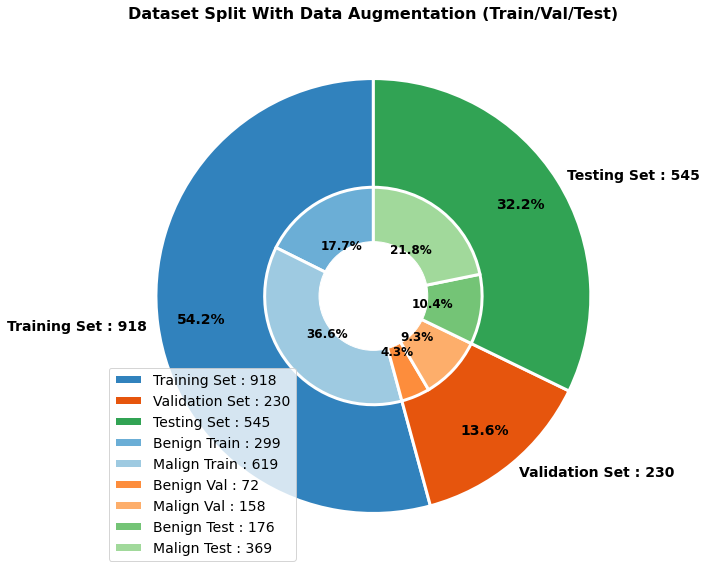

In [16]:
outer_names = [f'Training Set : {l_train_new}', f'Validation Set : {l_val_new}',f'Testing Set : {l_test_new}']
outer_size = [ l_train_new, l_val_new ,l_test_new]
outer_colors = cmap(np.arange(3)*4)
 
inner_names = [f'Benign Train : {l_train_b_new}', f'Malign Train : {l_train_m_new}', 
               f'Benign Val : {l_val_b_new}', f'Malign Val : {l_val_m_new}',
               f'Benign Test : {l_test_b_new}', f'Malign Test : {l_test_m_new}']
inner_size = [l_train_b_new, l_train_m_new, l_val_b_new, l_val_m_new,l_test_b_new,l_test_m_new]
inner_colors = cmap(np.array([1,2,5,6,9,10]))

# Setting the size of the figure
plt.figure(figsize=(10,10))
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.25, color='white')

# Plotting the outer pie
plt.pie(outer_size,  labels = outer_names,
       startangle=90, pctdistance =0.80 ,colors=outer_colors,
       autopct = '%1.1f%%', radius= 1.0,labeldistance=1.05,
       textprops ={ 'fontweight': 'bold','fontsize':14},
       wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" } )

# PLotting the inner pie
plt.pie(inner_size, 
        startangle=90, pctdistance =0.55,colors=inner_colors,
        autopct = '%1.1f%%',radius= 0.5,
       textprops ={'fontweight': 'bold' ,'fontsize':12}, 
       wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" } )

# Plotting the pie 
labels = outer_names + inner_names
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Dataset Split With Data Augmentation (Train/Val/Test)',{'fontweight': 'bold','fontsize':16})
plt.legend(labels,loc='lower left', fontsize =14)
plt.show()

# **CNN STRUCTURE :**

In [17]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

# Early stop  to avoid train overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

74850304/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **1.CONVOLUTIONAL NEURAL NETWORK (NO AUGMENTED DATA) :**

**Class Balancement :**

In [18]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.5351170568561874, 1: 0.7415185783521809}


**Model Fit With Class Balancement (Without Aug) :**

In [19]:
BATCH_SIZE = 32
history = model.fit(
    X_train,Y_train,batch_size = BATCH_SIZE,
    steps_per_epoch=int(X_train.shape[0] / BATCH_SIZE),
    epochs= 9,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop]
)

Epoch 1/9
28/28 [==============================] - 82s 1s/step - loss: 0.6689 - accuracy: 0.6551 - val_loss: 0.8351 - val_accuracy: 0.6870
Epoch 2/9
28/28 [==============================] - 41s 1s/step - loss: 0.4074 - accuracy: 0.8533 - val_loss: 1.0650 - val_accuracy: 0.6870
Epoch 3/9
28/28 [==============================] - 35s 1s/step - loss: 0.2639 - accuracy: 0.9289 - val_loss: 0.7884 - val_accuracy: 0.6870
Epoch 4/9
28/28 [==============================] - 35s 1s/step - loss: 0.2076 - accuracy: 0.9639 - val_loss: 0.5019 - val_accuracy: 0.7522
Epoch 5/9
28/28 [==============================] - 35s 1s/step - loss: 0.1784 - accuracy: 0.9763 - val_loss: 0.3687 - val_accuracy: 0.8217
Epoch 6/9
28/28 [==============================] - 35s 1s/step - loss: 0.1520 - accuracy: 0.9876 - val_loss: 0.2645 - val_accuracy: 0.9043
Epoch 7/9
28/28 [==============================] - 35s 1s/step - loss: 0.1252 - accuracy: 0.9966 - val_loss: 0.2760 - val_accuracy: 0.8913
Epoch 8/9
28/28 [==========

**Model Evaluation :**

In [20]:
test_loss1,test_acc1 =model.evaluate(X_test, Y_test)

18/18 [==============================] - 7s 407ms/step - loss: 0.2513 - accuracy: 0.9156


**Model Performance vs Class Unbalancement :**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
train_loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
epochs = range(1, len(val_loss1) + 1)

**Accuracy vs Class Balance Table :**

In [22]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Dataset","Best Accuracy"]) 
  
# Add rows 
myTable.add_row(["Training",
                 round(max(train_acc1),3)]) 
myTable.add_row(["Validation", 
                 round(max(val_acc1),3)]) 
myTable.add_row(["Testing",
                 round(test_acc1,3)]) 
  
print(myTable)

+------------+---------------+
|  Dataset   | Best Accuracy |
+------------+---------------+
|  Training  |     0.997     |
| Validation |     0.913     |
|  Testing   |     0.916     |
+------------+---------------+


**Accuracy Plot :**

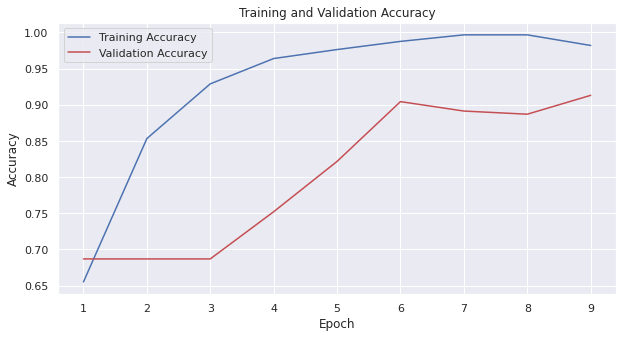

In [23]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc1, color='b', label='Training Accuracy')
plt.plot(epochs, val_acc1, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

**Loss Plot :**

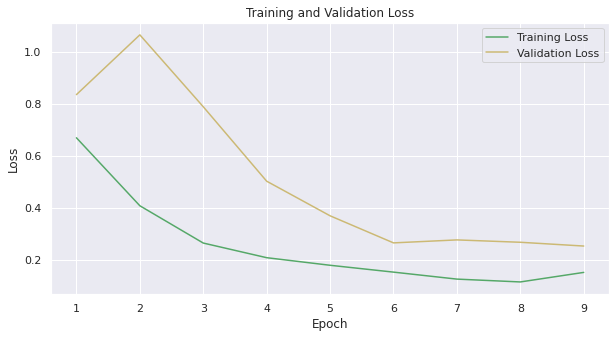

In [24]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss1, color='g', label='Training Loss')
plt.plot(epochs, val_loss1, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

**Confusion Matrix :**

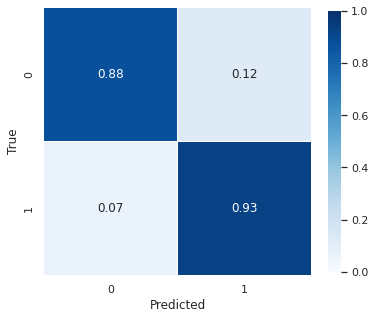

In [25]:
print_confusion_matrix(model, X_test, y_test)

# **DATA AUGMENTATION**

**Dataset Augmentation Transformation :**

In [27]:
data_gen = ImageDataGenerator(
    zoom_range  = 2, # randomly zoomed images
    rotation_range = 90, # randomly rotate images
    horizontal_flip = True, # randomly flip images
    width_shift_range=.2,
    height_shift_range=.2,
    vertical_flip = True, # randomly flip images
    fill_mode = 'reflect'
    )

# **CNN STRUCTURE :**

In [41]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

# Early stop  to avoid train overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **2.CONVOLUTIONAL NEURAL NETWORK (WITH DATA AUGMENTATION) :**


**Class Balancement :**

In [42]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.5351170568561874, 1: 0.7415185783521809}


**Model Fit With Data Augmentation (Balanced Classes) :**

In [43]:
BATCH_SIZE = 32

history = model.fit(
    data_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=int(X_train.shape[0] / BATCH_SIZE),
    epochs= 9,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop]
)

Epoch 1/9
28/28 [==============================] - 63s 1s/step - loss: 0.7438 - accuracy: 0.5598 - val_loss: 0.7117 - val_accuracy: 0.4913
Epoch 2/9
28/28 [==============================] - 35s 1s/step - loss: 0.6273 - accuracy: 0.7020 - val_loss: 0.6086 - val_accuracy: 0.7217
Epoch 3/9
28/28 [==============================] - 35s 1s/step - loss: 0.5109 - accuracy: 0.8047 - val_loss: 0.5237 - val_accuracy: 0.7348
Epoch 4/9
28/28 [==============================] - 36s 1s/step - loss: 0.4686 - accuracy: 0.8465 - val_loss: 0.4729 - val_accuracy: 0.7478
Epoch 5/9
28/28 [==============================] - 36s 1s/step - loss: 0.4249 - accuracy: 0.8657 - val_loss: 0.3735 - val_accuracy: 0.8435
Epoch 6/9
28/28 [==============================] - 36s 1s/step - loss: 0.3853 - accuracy: 0.8849 - val_loss: 0.3457 - val_accuracy: 0.8565
Epoch 7/9
28/28 [==============================] - 35s 1s/step - loss: 0.3445 - accuracy: 0.8984 - val_loss: 0.2879 - val_accuracy: 0.9217
Epoch 8/9
28/28 [==========


**Model Evaluation :**

In [44]:
test_loss2, test_acc2 = model.evaluate(X_test, Y_test)

18/18 [==============================] - 6s 326ms/step - loss: 0.2033 - accuracy: 0.9266


**Model Performance vs Class Unbalancement :**

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
train_loss2 = history.history['loss']
val_loss2 = history.history['val_loss']
epochs = range(1, len(val_loss2) + 1)

**Accuracy vs Class Balance Table :**

In [46]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Dataset","Best Accuracy"]) 
  
# Add rows 
myTable.add_row(["Training",
                 round(max(train_acc2),3)]) 
myTable.add_row(["Validation",
                 round(max(val_acc2),3)]) 
myTable.add_row(["Testing",
                 round(test_acc2,3)])
  
print(myTable)

+------------+---------------+
|  Dataset   | Best Accuracy |
+------------+---------------+
|  Training  |     0.905     |
| Validation |     0.926     |
|  Testing   |     0.927     |
+------------+---------------+


**Accuracy Plot :**

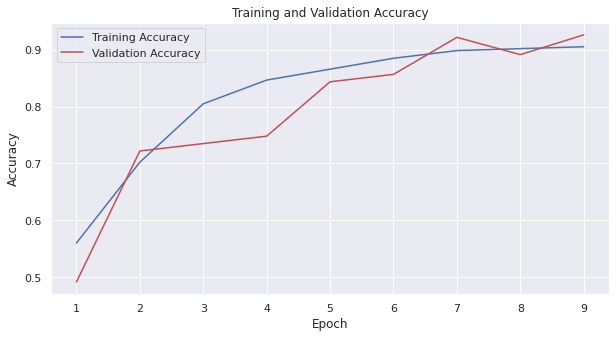

In [47]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc2, color='b', label='Training Accuracy')
plt.plot(epochs, val_acc2, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

**Loss Plot :**

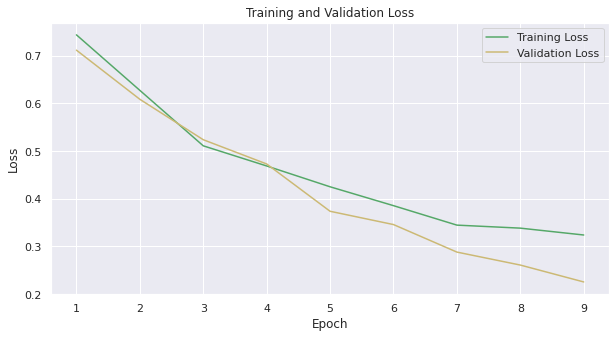

In [48]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss2, color='g', label='Training Loss')
plt.plot(epochs, val_loss2, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

**Confusion Matrix :**

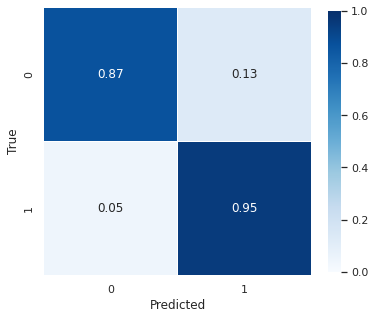

In [49]:
print_confusion_matrix(model, X_test, y_test)

# **CNN DATASET STAIN NORMALIZED :**

In [50]:
#!pip install staintools
#!pip install spams
#import staintools
#import spams

**Reference Image for Stain Normalization :**

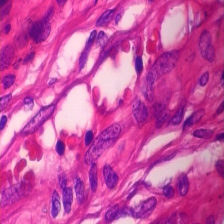

In [51]:
stain_ref = cv2.imread('/content/drive/MyDrive/deep_project/Stain_ref/stain_1.png')
stain_ref = cv2.resize(stain_ref, (224,224), 0)
cv2_imshow(stain_ref)

**Stain Normalized Dataset Creation :** 
A.A. The Code require long running-time to create the stained dataset.

In [52]:
'''
x_test_stain = []
x_train_stain = []
x_val_stain = []

normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)

target = stain_ref
target = staintools.LuminosityStandardizer.standardize(target)
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)

for i in tqdm(range(len(X_train))):
  to_transform = X_train[i]
  to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
  transformed = normalizer.transform(to_transform)
  x_train_stain.append(transformed)
x_train_stain = np.array(x_train_stain)

for i in tqdm(range(len(X_test))):
  to_transform = X_test[i]
  to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
  transformed = normalizer.transform(to_transform)
  x_test_stain.append(transformed)
x_test_stain = np.array(x_test_stain)

for i in tqdm(range(len(X_val))):
  to_transform = X_val[i]
  to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
  transformed = normalizer.transform(to_transform)
  x_val_stain.append(transformed)
x_val_stain = np.array(x_val_stain)'''

"\nx_test_stain = []\nx_train_stain = []\nx_val_stain = []\n\nnormalizer = staintools.StainNormalizer(method='vahadane')\nnormalizer.fit(target)\n\ntarget = stain_ref\ntarget = staintools.LuminosityStandardizer.standardize(target)\nnormalizer = staintools.StainNormalizer(method='vahadane')\nnormalizer.fit(target)\n\nfor i in tqdm(range(len(X_train))):\n  to_transform = X_train[i]\n  to_transform = staintools.LuminosityStandardizer.standardize(to_transform)\n  transformed = normalizer.transform(to_transform)\n  x_train_stain.append(transformed)\nx_train_stain = np.array(x_train_stain)\n\nfor i in tqdm(range(len(X_test))):\n  to_transform = X_test[i]\n  to_transform = staintools.LuminosityStandardizer.standardize(to_transform)\n  transformed = normalizer.transform(to_transform)\n  x_test_stain.append(transformed)\nx_test_stain = np.array(x_test_stain)\n\nfor i in tqdm(range(len(X_val))):\n  to_transform = X_val[i]\n  to_transform = staintools.LuminosityStandardizer.standardize(to_transfo

**Stain Normalized Dataset Saving :** In order to reduce time for the staining processing step, we've saved the stained dataset in the current folders:
*   Stain Normalized TrainigSet Path : 
  > X_train_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_train_norm.pickle"

  > Y_train_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_train_norm.pickle"

*   Stain Normalized TestingSet Path :  
  > X_test_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/test/x_test_norm.pickle"

  > Y_test_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/test/y_test_norm.pickle"
*   Stain Normalized ValidationSet Path : 
  > X_val_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_val_norm.pickle"
  
  > Y_val_stain : "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_val_norm.pickle"



In [53]:
'''
pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_train_norm.pickle", "wb")
pickle.dump(x_train_stain, pickle_out)
pickle_out.close()
pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_train_norm.pickle", "wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/x_test_norm.pickle", "wb")
pickle.dump(x_test_stain, pickle_out)
pickle_out.close()
pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/y_test_norm.pickle", "wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_val_norm.pickle", "wb")
pickle.dump(x_val_stain, pickle_out)
pickle_out.close()
pickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_val_norm.pickle", "wb")
pickle.dump(Y_val, pickle_out)
pickle_out.close()
'''

'\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_train_norm.pickle", "wb")\npickle.dump(x_train_stain, pickle_out)\npickle_out.close()\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_train_norm.pickle", "wb")\npickle.dump(Y_train, pickle_out)\npickle_out.close()\n\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/x_test_norm.pickle", "wb")\npickle.dump(x_test_stain, pickle_out)\npickle_out.close()\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/y_test_norm.pickle", "wb")\npickle.dump(Y_test, pickle_out)\npickle_out.close()\n\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_val_norm.pickle", "wb")\npickle.dump(x_val_stain, pickle_out)\npickle_out.close()\npickle_out = open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_val_norm.pickle", "wb")\npickle.dump(Y_val, pickle_out)\npickle_out.close()\n'

**Stain Normalized Dataset Loading :**

In [54]:
with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/x_test_norm.pickle", "rb") as input_file:
  X_test_stain = pickle.load(input_file)
with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/test/y_test_norm.pickle", "rb") as input_file:
  Y_test_stain = pickle.load(input_file) # For the CNN ([0,1]/[1,0])
y_test_stain = np.argmax(Y_test_stain,axis=1) # For the Confusion Matrix (1/0)

with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_train_norm.pickle", "rb") as input_file:
  X_train_stain = pickle.load(input_file)
with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_train_norm.pickle", "rb") as input_file:
  Y_train_stain = pickle.load(input_file) # For the CNN ([0,1]/[1,0])
y_train_stain = np.argmax(Y_train_stain,axis=1) # For Classes Weights (1/0)

with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_val_norm.pickle", "rb") as input_file:
  X_val_stain = pickle.load(input_file)
with open("/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_val_norm.pickle", "rb") as input_file:
  Y_val_stain = pickle.load(input_file) # For the CNN ([0,1]/[1,0])
y_val_stain = np.argmax(Y_val_stain,axis=1) # For Classes Weights (1/0)

**Stain Normalized Dataset Dims :**

In [55]:
# TrainingSet
l_train_b_stain = sum(y_train_stain==0) # Benign
l_train_m_stain = sum(y_train_stain==1) # Malign
l_train_stain = l_train_b_stain + l_train_m_stain # Malign + Benign
# ValidationSet
l_val_b_stain = sum(y_val_stain==0) # Benign
l_val_m_stain = sum(y_val_stain==1) # Malign
l_val_stain = l_val_b_stain + l_val_m_stain # Malign + Benign
# TestingSet
l_test_b_stain = sum(y_test_stain==0) # Benign
l_test_m_stain = sum(y_test_stain==1) # Malign
l_test_stain = l_test_b_stain + l_test_m_stain # Malign + Benign
# Entire Dataset
l_tot_b_stain = l_test_b_stain + l_train_b_stain + l_val_b_stain # Benign
l_tot_m_stain= l_test_m_stain + l_train_m_stain + l_val_m_stain # Malign
l_tot_stain = l_test_stain + l_train_stain + l_val_stain # Malign + Benign

# **CNN STRUCTURE :**

In [56]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

# Early stop  to avoid train overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **3.CONVOLUTIONAL NEURAL NETWORK (WITH STAIN NORMALIZATION) :**


**Classes Weights :**

In [57]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train_stain),
                                                 y = y_train_stain)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.5506756756756757, 1: 0.7379421221864951}


**Model Fit With Class Balancement :**

In [58]:
BATCH_SIZE = 32
history = model.fit(
    X_train_stain,Y_train_stain,batch_size = BATCH_SIZE,
    steps_per_epoch=int(X_train_stain.shape[0] / BATCH_SIZE),
    epochs= 9,
    validation_data=(X_val_stain, Y_val_stain),
    class_weight = class_weights,
    callbacks=[early_stop]
)

Epoch 1/9
28/28 [==============================] - 65s 1s/step - loss: 0.7808 - accuracy: 0.5446 - val_loss: 0.6471 - val_accuracy: 0.6739
Epoch 2/9
28/28 [==============================] - 35s 1s/step - loss: 0.6117 - accuracy: 0.6817 - val_loss: 0.5662 - val_accuracy: 0.6826
Epoch 3/9
28/28 [==============================] - 35s 1s/step - loss: 0.4339 - accuracy: 0.8115 - val_loss: 0.5296 - val_accuracy: 0.7087
Epoch 4/9
28/28 [==============================] - 35s 1s/step - loss: 0.3182 - accuracy: 0.8962 - val_loss: 0.4605 - val_accuracy: 0.7783
Epoch 5/9
28/28 [==============================] - 35s 1s/step - loss: 0.2339 - accuracy: 0.9537 - val_loss: 0.4274 - val_accuracy: 0.8304
Epoch 6/9
28/28 [==============================] - 35s 1s/step - loss: 0.1954 - accuracy: 0.9729 - val_loss: 0.4032 - val_accuracy: 0.8435
Epoch 7/9
28/28 [==============================] - 35s 1s/step - loss: 0.1693 - accuracy: 0.9898 - val_loss: 0.4133 - val_accuracy: 0.8261
Epoch 8/9
28/28 [==========

**Model Evaluation :**

In [59]:
test_loss3,test_acc3 = model.evaluate(X_test_stain, Y_test_stain)

18/18 [==============================] - 6s 324ms/step - loss: 0.3599 - accuracy: 0.8495


**Model Performance vs Class Unbalancement :**

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
train_loss3 = history.history['loss']
val_loss3 = history.history['val_loss']
epochs = range(1, len(val_loss3) + 1)

**Accuracy vs Class Balance Table :**

In [61]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Dataset","Best Accuracy"]) 
  
# Add rows 
myTable.add_row(["Training",
                 round(max(train_acc3),3)]) 
myTable.add_row(["Validation",
                 round(max(val_acc3),3)]) 
myTable.add_row(["Testing",
                 round(test_acc3,3)])
  
print(myTable)

+------------+---------------+
|  Dataset   | Best Accuracy |
+------------+---------------+
|  Training  |     0.991     |
| Validation |     0.843     |
|  Testing   |      0.85     |
+------------+---------------+


**Accuracy Plot :**

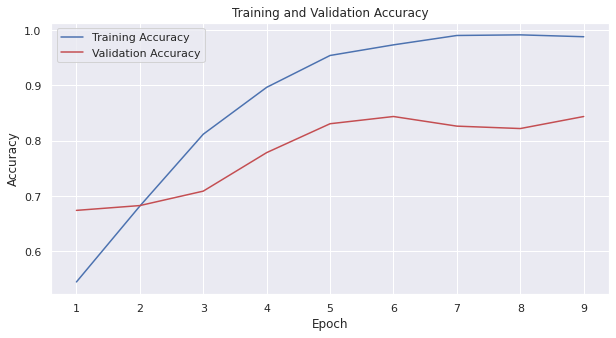

In [62]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc3, color='b', label='Training Accuracy')
plt.plot(epochs, val_acc3, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

**Loss Plot :**

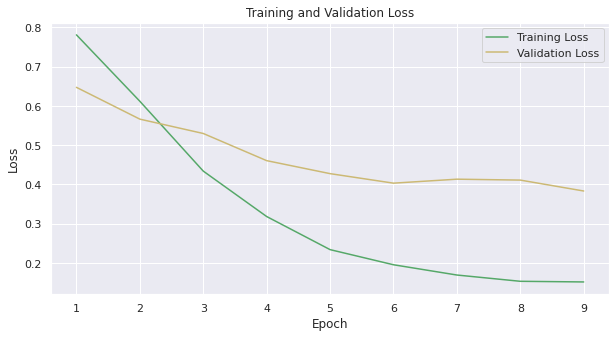

In [63]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss3, color='g', label='Training Loss')
plt.plot(epochs, val_loss3, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

**Confusion Matrix :**

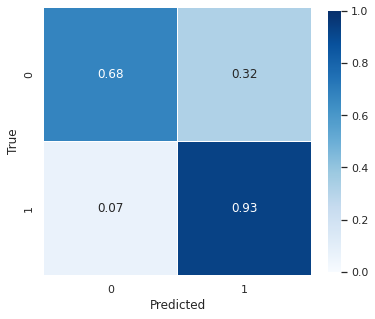

In [64]:
print_confusion_matrix(model, X_test_stain, y_test_stain)

# **CNN STRUCTURE :**

In [65]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

# Early stop  to avoid train overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **4.CONVOLUTIONAL NEURAL NETWORK (DATA AUGMENTATION APPLIED TO NORMALIZED DATASET) :**


**Model Fit With Class Balancement :**

In [66]:
BATCH_SIZE = 32
history = model.fit(
    data_gen.flow(X_train_stain,Y_train_stain,batch_size = BATCH_SIZE),
    steps_per_epoch=int(X_train_stain.shape[0] / BATCH_SIZE),
    epochs= 9,
    validation_data=(X_val_stain, Y_val_stain),
    callbacks=[early_stop]
)

Epoch 1/9
28/28 [==============================] - 65s 1s/step - loss: 0.8197 - accuracy: 0.5339 - val_loss: 0.6621 - val_accuracy: 0.6609
Epoch 2/9
28/28 [==============================] - 36s 1s/step - loss: 0.7598 - accuracy: 0.5959 - val_loss: 0.6334 - val_accuracy: 0.6696
Epoch 3/9
28/28 [==============================] - 35s 1s/step - loss: 0.7061 - accuracy: 0.6174 - val_loss: 0.5894 - val_accuracy: 0.6957
Epoch 4/9
28/28 [==============================] - 36s 1s/step - loss: 0.6431 - accuracy: 0.7043 - val_loss: 0.5863 - val_accuracy: 0.6957
Epoch 5/9
28/28 [==============================] - 36s 1s/step - loss: 0.6200 - accuracy: 0.7336 - val_loss: 0.4980 - val_accuracy: 0.7348
Epoch 6/9
28/28 [==============================] - 35s 1s/step - loss: 0.5666 - accuracy: 0.7393 - val_loss: 0.6624 - val_accuracy: 0.6870
Epoch 7/9
28/28 [==============================] - 35s 1s/step - loss: 0.5216 - accuracy: 0.7709 - val_loss: 0.4751 - val_accuracy: 0.8087
Epoch 8/9
28/28 [==========

**Model Evaluation :**

In [67]:
test_loss4,test_acc4 = model.evaluate(X_test_stain,Y_test_stain)

18/18 [==============================] - 6s 326ms/step - loss: 0.4989 - accuracy: 0.8073


**Model Performance vs Class Unbalancement :**

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
train_loss4 = history.history['loss']
val_loss4 = history.history['val_loss']
epochs = range(1, len(val_loss4) + 1)

**Accuracy vs Classes Unbalancement:**

In [69]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Dataset", "BestAccuracy"]) 
  
# Add rows 

myTable.add_row(["Training", 
                 round(max(train_acc4),3)]) 
myTable.add_row(["Validation", 
                 round(max(val_acc4),3)]) 
myTable.add_row(["Testing",
                 round(test_acc4,3)])
  
print(myTable)

+------------+--------------+
|  Dataset   | BestAccuracy |
+------------+--------------+
|  Training  |    0.808     |
| Validation |     0.83     |
|  Testing   |    0.807     |
+------------+--------------+


**Accuracy Plot :**

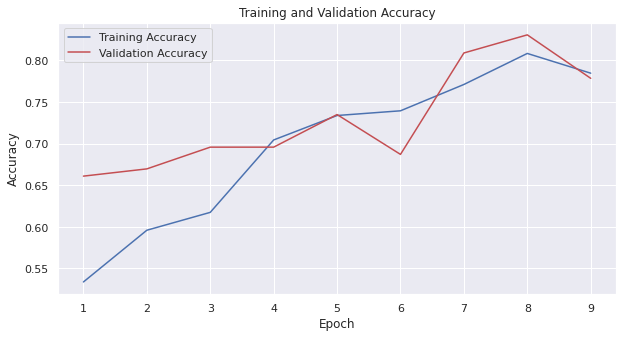

In [70]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc4, color='b', label='Training Accuracy')
plt.plot(epochs, val_acc4, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

**Loss Plot :**

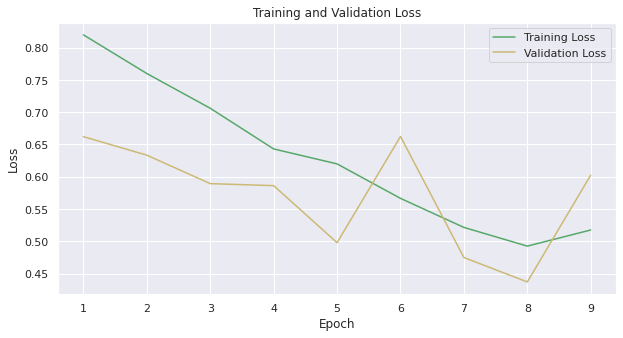

In [71]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss4, color='g', label='Training Loss')
plt.plot(epochs, val_loss4, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

**Confusion Matrix :**

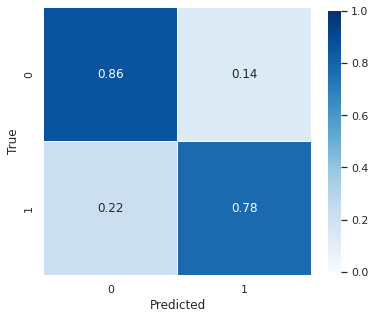

In [72]:
print_confusion_matrix(model, X_test_stain, y_test_stain)

# **COLOR AUGMENTATION :** 
From each augmented image we've performed a stain normalization using several type of reference images. With this procedure we should increment the color data variability by using different stains for each image. We apply color data augmentation to the original test data.

**Stain Reference Images Loading :** 

In [73]:
!pip install staintools
!pip install spams
import staintools
import spams

  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14072 sha256=bcec134e3896a58eadda147260b806c4eddf20a2b42ea09dacea82db79041ddf
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for spams: filename=spams-2.6.2.5-cp37-cp37m-linux_x86_64.whl size=4516320 sha256=d518e9f37319b1cb07626c96f658e03df7690bceea24fdaaa52788a57efcaf7a
  Stored in directory: /root/.cache/pip/wheels/91/49/fe/de10cfc13193b9c7780edc871736c844f4a2c5151490e4c97f
Successfully built spams


In [74]:
stain_ref = np.array(Dataset_loader('/content/drive/MyDrive/deep_project/Stain_ref',224))

100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


**Reference Image,Moving Image,Transformed Image Plot:** 

Stain Reference # 8
['Reference Image', 'Moving Image', 'Normalized Image']


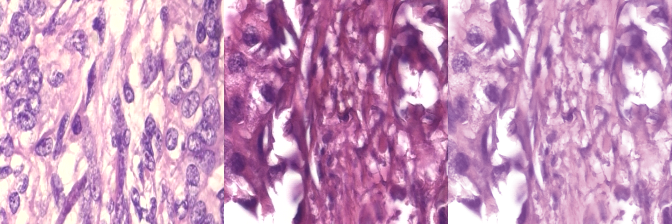

In [75]:
import staintools
import spams

idx_stain_ref_sel = random.randrange(len(stain_ref))
target = stain_ref[idx_stain_ref_sel] # Random Selection of the Reference Image
target = staintools.LuminosityStandardizer.standardize(target)
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)
to_transform = X_train[random.randrange(len(X_train))] # Random Selection of the Image to Transform 
to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
transformed = normalizer.transform(to_transform) # Transformed Image 
img = cv2.hconcat([target,to_transform,transformed])
print("=================")
print(f"Stain Reference # {idx_stain_ref_sel}")
print(["Reference Image","Moving Image","Normalized Image"])
print("=================")
cv2_imshow(img)

**Best Stain Reference Images Selection :**
By manual visual inspection we select the "best" reference images to use for color augmentation.

In [76]:
good_ref_idx = [0,1,2,4,5,7,8,10,11]

**Color Augmented Dataset Generation :**

In [77]:
'''
x_train_col = []
x_val_col = []
y_train_col = []
y_val_col = []

for i in tqdm(range(len(stain_ref))):
  target = stain_ref[i]
  target = staintools.LuminosityStandardizer.standardize(target)
  normalizer = staintools.StainNormalizer(method='vahadane')
  normalizer.fit(target)
  for j in range(160):
    ind = random.randrange(len(X_train_aug))
    to_transform = X_train_aug[ind]
    to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
    transformed = normalizer.transform(to_transform)
    x_train_col.append(transformed)
    y_train_col.append(Y_train_aug[ind])
x_train_col = np.array(x_train_col)
y_train_col = np.array(y_train_col)

for i in tqdm(range(len(stain_ref))):
  target = stain_ref[i]
  target = staintools.LuminosityStandardizer.standardize(target)
  normalizer = staintools.StainNormalizer(method='vahadane')
  normalizer.fit(target)
  for j in range(40):
    ind = random.randrange(len(X_val_aug))
    to_transform = X_val_aug[ind]
    to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
    transformed = normalizer.transform(to_transform)
    x_val_col.append(transformed)
    y_val_col.append(Y_val_aug[ind])
x_val_col = np.array(x_val_col)
y_val_col = np.array(y_val_col)
'''

"\nx_train_col = []\nx_val_col = []\ny_train_col = []\ny_val_col = []\n\nfor i in tqdm(range(len(stain_ref))):\n  target = stain_ref[i]\n  target = staintools.LuminosityStandardizer.standardize(target)\n  normalizer = staintools.StainNormalizer(method='vahadane')\n  normalizer.fit(target)\n  for j in range(160):\n    ind = random.randrange(len(X_train_aug))\n    to_transform = X_train_aug[ind]\n    to_transform = staintools.LuminosityStandardizer.standardize(to_transform)\n    transformed = normalizer.transform(to_transform)\n    x_train_col.append(transformed)\n    y_train_col.append(Y_train_aug[ind])\nx_train_col = np.array(x_train_col)\ny_train_col = np.array(y_train_col)\n\nfor i in tqdm(range(len(stain_ref))):\n  target = stain_ref[i]\n  target = staintools.LuminosityStandardizer.standardize(target)\n  normalizer = staintools.StainNormalizer(method='vahadane')\n  normalizer.fit(target)\n  for j in range(40):\n    ind = random.randrange(len(X_val_aug))\n    to_transform = X_val_aug

**Color Augmented Dataset Saving/Loading Path :**

In [78]:
# Trainig Set
x_train_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_train_col.pickle"
y_train_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_train_col.pickle"
# Validation Set
x_val_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/x_val_col.pickle"
y_val_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/train/y_val_col.pickle"
# Validation Set
x_test_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/test/x_test_col.pickle"
y_test_col_path = "/content/drive/MyDrive/deep_project/BreaKHis 400X/test/y_test_col.pickle"

**Color Augmented Dataset Saving :**

In [79]:
'''
pickle_out = open("x_train_col_path", "wb")
pickle.dump(x_train_col, pickle_out)
pickle_out.close()
pickle_out = open("y_train_col_path", "wb")
pickle.dump(y_train_col, pickle_out)
pickle_out.close()

pickle_out = open("x_val_col_path", "wb")
pickle.dump(x_val_col, pickle_out)
pickle_out.close()
pickle_out = open("y_val_col_path", "wb")
pickle.dump(y_val_col, pickle_out)
pickle_out.close()

pickle_out = open("x_test_col_path", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()
pickle_out = open("y_test_col_path, "wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()
'''

'\npickle_out = open("x_train_col_path", "wb")\npickle.dump(x_train_col, pickle_out)\npickle_out.close()\npickle_out = open("y_train_col_path", "wb")\npickle.dump(y_train_col, pickle_out)\npickle_out.close()\n\npickle_out = open("x_val_col_path", "wb")\npickle.dump(x_val_col, pickle_out)\npickle_out.close()\npickle_out = open("y_val_col_path", "wb")\npickle.dump(y_val_col, pickle_out)\npickle_out.close()\n\npickle_out = open("x_test_col_path", "wb")\npickle.dump(X_test, pickle_out)\npickle_out.close()\npickle_out = open("y_test_col_path, "wb")\npickle.dump(Y_test, pickle_out)\npickle_out.close()\n'

**Color Augmented Dataset Loading :**

In [80]:
# Trainig Set
with open(x_train_col_path, "rb") as input_file:
  X_train_col = pickle.load(input_file)
with open(y_train_col_path, "rb") as input_file:
  Y_train_col = pickle.load(input_file) # for CNN ([0,1]/[1,0])
y_train_col = np.argmax(Y_train_col,axis=1)
# Validation Set
with open(x_val_col_path, "rb") as input_file:
  X_val_col = pickle.load(input_file)
with open(y_val_col_path, "rb") as input_file:
  Y_val_col = pickle.load(input_file) # for CNN ([0,1]/[1,0])
y_val_col = np.argmax(Y_val_col,axis=1)
# Testing Set
with open(x_test_col_path, "rb") as input_file:
  X_test_col = pickle.load(input_file)
with open(y_test_col_path, "rb") as input_file:
  Y_test_col = pickle.load(input_file) # for CNN ([0,1]/[1,0])
y_test_col = np.argmax(Y_test_col,axis=1)

**Observation :** The testing set X_test_col/Y_test_col is the same of X_test_new/Y_test_new used for the first CNN. We've name X_test_new/Y_test_new to X_test_col/Y_test_col just for simmetry.

# **CNN STRUCTURE :**

In [94]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

# Early stop  to avoid train overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **5.CONVOLUTIONAL NEURAL NETWORK (WITH COLOR AUGMENTATION) :**


**Model Fit with Class Balancement :**

In [92]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train_col),
                                                 y = y_train_col)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.4860681114551084, 1: 0.7535321821036107}


In [95]:
BATCH_SIZE = 32
history = model.fit(
    data_gen.flow(X_train_col,Y_train_col,batch_size = BATCH_SIZE),
    steps_per_epoch=int(X_train_col.shape[0] / BATCH_SIZE),
    epochs= 9,
    validation_data=(X_val_col, Y_val_col),
    callbacks=[early_stop],
    class_weight = class_weights
)

Epoch 1/9
30/30 [==============================] - 67s 1s/step - loss: 0.7948 - accuracy: 0.5271 - val_loss: 0.6585 - val_accuracy: 0.6875
Epoch 2/9
30/30 [==============================] - 38s 1s/step - loss: 0.8186 - accuracy: 0.5031 - val_loss: 0.6351 - val_accuracy: 0.7240
Epoch 3/9
30/30 [==============================] - 38s 1s/step - loss: 0.7387 - accuracy: 0.5750 - val_loss: 0.6169 - val_accuracy: 0.7240
Epoch 4/9
30/30 [==============================] - 38s 1s/step - loss: 0.7014 - accuracy: 0.6042 - val_loss: 0.5997 - val_accuracy: 0.6875
Epoch 5/9
30/30 [==============================] - 38s 1s/step - loss: 0.7029 - accuracy: 0.5917 - val_loss: 0.5789 - val_accuracy: 0.7031
Epoch 6/9
30/30 [==============================] - 38s 1s/step - loss: 0.6511 - accuracy: 0.6365 - val_loss: 0.7184 - val_accuracy: 0.7031
Epoch 7/9
30/30 [==============================] - 38s 1s/step - loss: 0.6474 - accuracy: 0.6479 - val_loss: 0.7359 - val_accuracy: 0.7083
Epoch 8/9
30/30 [==========

**Model Evaluation :**

In [96]:
test_loss5,test_acc5 = model.evaluate(X_test_col, Y_test_col)

18/18 [==============================] - 10s 326ms/step - loss: 0.5959 - accuracy: 0.7321


**MODEL PERFORMANCE VS CLASS UNBALACEMENT :**

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
train_loss5 = history.history['loss']
val_loss5 = history.history['val_loss']
epochs = range(1, len(val_loss5) + 1)

In [98]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Dataset","Best Accuracy"]) 
  
# Add rows 
myTable.add_row(["Training",
                 round(max(train_acc5),3)]) 
myTable.add_row(["Validation", 
                 round(max(val_acc5),3)]) 
myTable.add_row(["Testing",
                 round(test_acc5,3)])
  
print(myTable)

+------------+---------------+
|  Dataset   | Best Accuracy |
+------------+---------------+
|  Training  |     0.671     |
| Validation |     0.724     |
|  Testing   |     0.732     |
+------------+---------------+


**Accuracy Plot :**

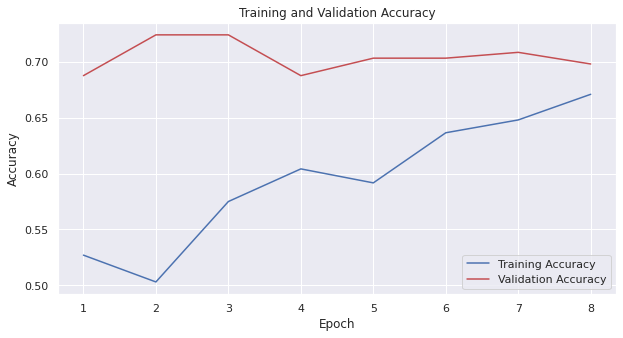

In [99]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc5, color='b', label='Training Accuracy')
plt.plot(epochs, val_acc5, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

**Loss Plot :**

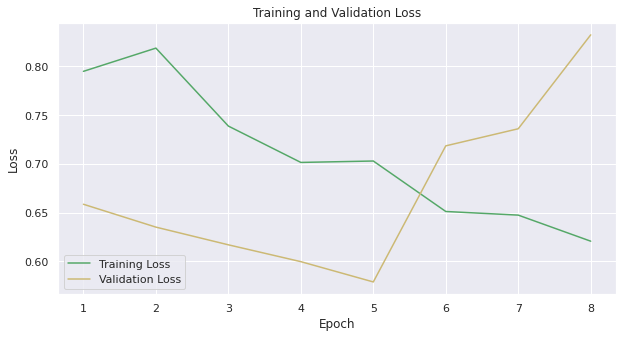

In [100]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss5, color='g', label='Training Loss')
plt.plot(epochs, val_loss5, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Confusion Matrix:**

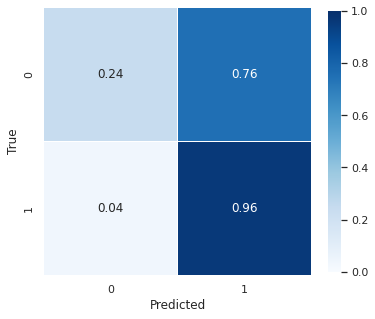

In [101]:
print_confusion_matrix(model, X_test, y_test)

# **FINAL OBSERVATIONS :**

In [103]:
from prettytable import PrettyTable  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["ID CNN","Data Augmentation",
                       "Stain Normalization","Color Augmentation","Test Loss","Test Accuracy"]) 
# Add rows 
myTable.add_row(["001","No","No","No",round(test_loss1,2),round(test_acc1,2)])
myTable.add_row(["002","Yes","No","No",round(test_loss2,2),round(test_acc2,2)])
myTable.add_row(["003","No","Yes","No",round(test_loss3,2),round(test_acc3,2)])
myTable.add_row(["004","Yes","Yes","No",round(test_loss4,2),round(test_acc4,2)])
myTable.add_row(["004","Yes","No","Yes",round(test_loss5,2),round(test_acc5,2)])
print(myTable)

+--------+-------------------+---------------------+--------------------+-----------+---------------+
| ID CNN | Data Augmentation | Stain Normalization | Color Augmentation | Test Loss | Test Accuracy |
+--------+-------------------+---------------------+--------------------+-----------+---------------+
|  001   |         No        |          No         |         No         |    0.25   |      0.92     |
|  002   |        Yes        |          No         |         No         |    0.2    |      0.93     |
|  003   |         No        |         Yes         |         No         |    0.36   |      0.85     |
|  004   |        Yes        |         Yes         |         No         |    0.5    |      0.81     |
|  004   |        Yes        |          No         |        Yes         |    0.6    |      0.73     |
+--------+-------------------+---------------------+--------------------+-----------+---------------+
